# Lab 05

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Predictive Analytics
- Course ID: BDM500NAA.05379.2237
- Professor: Dr. Tamanna Eini Keleshteri

<b>All my observations are highlighted by <font color='limegreen'>this color</font> and comment out in the code.</b>

This lab on Decision Trees is a Python adaptation of p. 324-331 of "Introduction to Statistical Learning with
Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith
College for SDS293: Machine Learning (Spring 2016).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise. We'll append this onto our dataFrame using the `.map()` function, and then do a little data cleaning to tidy things up:

In [3]:
df3 = pd.read_csv('Carseats.csv')#.drop('Unnamed: 0', axis=1)
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [4]:
X = df3.drop(['Sales', 'High'], axis = 1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter:

In [5]:
classification_tree_carseats = DecisionTreeClassifier(max_depth = 6)
classification_tree_carseats.fit(X_train, y_train)
classification_tree_carseats.score(X_train, y_train)

0.921875

We see that the training accuracy is 92.2%.

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

In [6]:
export_graphviz(classification_tree_carseats, 
                out_file = "carseat_tree.dot", 
                feature_names = X_train.columns)

#with open("carseat_tree.dot") as f:
#    dot_graph = f.read()
#graphviz.Source(dot_graph)

# Instead of showing the tree graph here, I observed it by installing the extention (Graphviz (dot) language support for Visual Studio Code) in VS code.

The most important indicator of `High` sales appears to be `Price`.

Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix, which shows that we are making correct predictions for
around 72.5% of the test data set:

In [7]:
pred = classification_tree_carseats.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm) 
# (37+21)/80 = 0.745

     No  Yes
No   36   15
Yes   7   22


# 2 Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. First, we create a
training set, and fit the tree to the training data using `medv` (median home value) as our response:

In [8]:
boston_df = pd.read_csv('Boston.csv')
#boston_df = boston = load_boston()
X = boston_df.drop('medv', axis = 1)
y = boston_df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
regr_tree_boston.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

<font color='limegreen'>

Comment:
- sklearn.datasets.load_boston() is out of date, so I manually downloaded the Boston datasets from Github that you provided in the lecture.

Link: https://github.com/selva86/datasets/tree/master

</font>

Let's take a look at the tree:

In [9]:
export_graphviz(regr_tree_boston, 
                out_file = "boston_tree.dot", 
                feature_names = X_train.columns)

#with open("boston_tree.dot") as f:
#    dot_graph = f.read()
#graphviz.Source(dot_graph)

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$45,766 for larger homes (`rm>=7.4351`) in suburbs in which residents have high socioeconomic
status (`lstat<7.81`).

Now let's see how it does on the test data:

35.406215828790266

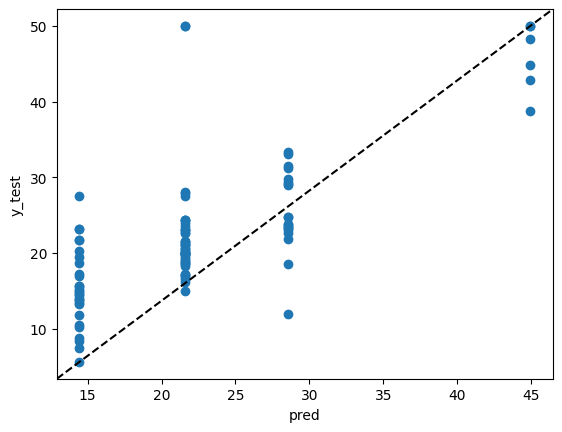

In [10]:
pred = regr_tree_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

<font color='limegreen'>

# Apply Iris Data

As you said, the following processes are exactly the same operations as the link toward Iris data.

</font>

References:
- https://www.youtube.com/watch?v=nnUHcLZ8Q_k&t=450s
- https://www.youtube.com/watch?v=s5Plqr0Y7D8&t=1091s

In [9]:
# loading dataset and assign data to feature matrix and a target vector
from sklearn import datasets
iris = datasets.load_iris()
iris_X = iris['data']
iris_y = iris['target']

In [10]:
# get the feature matrix and target vector as df
iris_df = pd.DataFrame(np.c_[iris_X, iris_y], columns=iris['feature_names'] + ['target'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [22]:
# calculating Gini Index based on given thresholds

def calculate_gini(df: pd.DataFrame, thresholds: list, y_name: str):
    """
    Calculate the Gini index based on thresholds for each features
    """
    # total rows
    n = len(df)
    # column names
    cols = df.columns
    # gini(key: feature, values: Gini index)
    gini = {}
    for i, t in enumerate(thresholds):
        # feature name
        X_name = cols[i]
        # assign numerical values
        gini[X_name] = 0
        # define output1
        output1 = f'Gini({X_name}) = '
        # filterd dfs
        filter1 = df[df[X_name] > t][y_name].value_counts()
        filter2 = df[df[X_name] <= t][y_name].value_counts()
        # calculate gini index based on each feature
        for j, f in enumerate([filter1, filter2]):
            # number of instances
            num_insts = sum(f)
            # define output2
            math2_ = '>' if j == 0 else '<='
            output2 = f'Gini({X_name} {math2_} {t}) = 1 '
            # gini index of each feature category
            gini_each_cat = 1
            # update gini_each_cat
            for v in f.values:
                output2 += f' - ({v}/{num_insts})**2'
                gini_each_cat -= (v/num_insts)**2
            print(output2)
            # update the weighted sum of gini index
            math1_ = ' + ' if j == 0 else ''
            output1 += f'({num_insts}/{n} * {gini_each_cat})' + math1_
            gini[X_name] += (num_insts/n) * gini_each_cat

        print(output1)
        print('')


    return gini

mean_features = list(iris_df.iloc[:, :-1].mean(axis=0).values)
calculate_gini(iris_df, mean_features, 'target')

Gini(sepal length (cm) > 5.843333333333335) = 1  - (44/70)**2 - (26/70)**2
Gini(sepal length (cm) <= 5.843333333333335) = 1  - (50/80)**2 - (24/80)**2 - (6/80)**2
Gini(sepal length (cm)) = (70/150 * 0.46693877551020413) + (80/150 * 0.51375)

Gini(sepal width (cm) > 3.057333333333334) = 1  - (42/67)**2 - (17/67)**2 - (8/67)**2
Gini(sepal width (cm) <= 3.057333333333334) = 1  - (42/83)**2 - (33/83)**2 - (8/83)**2
Gini(sepal width (cm)) = (67/150 * 0.5284027623078638) + (83/150 * 0.5765713456234577)

Gini(petal length (cm) > 3.7580000000000027) = 1  - (50/93)**2 - (43/93)**2
Gini(petal length (cm) <= 3.7580000000000027) = 1  - (50/57)**2 - (7/57)**2
Gini(petal length (cm)) = (93/150 * 0.4971673025783328) + (57/150 * 0.21545090797168373)

Gini(petal width (cm) > 1.199333333333334) = 1  - (50/90)**2 - (40/90)**2
Gini(petal width (cm) <= 1.199333333333334) = 1  - (50/60)**2 - (10/60)**2
Gini(petal width (cm)) = (90/150 * 0.49382716049382713) + (60/150 * 0.2777777777777777)



{'sepal length (cm)': 0.49190476190476196,
 'sepal width (cm)': 0.5550560450758257,
 'petal length (cm)': 0.39011507262780615,
 'petal width (cm)': 0.40740740740740733}

<font color='limegreen'>

Observations:

- Based on the Gini calculation that is shown above, the feature "petal length (cm)" showed the lowest gini index value.
- Therefore, this feature should be on the top of the tree, and we can think that this feature is the most important one.
- However, if we change the thresholds, the result might be drastically changed; in this case, I just applied the mean of each feature as each threshold.


</font>

In [12]:
# This section is the same operation as the second reference

# split train and test split
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y, train_size = 0.8, random_state = 0)

# create model
model = DecisionTreeClassifier(criterion='gini')
model.fit(iris_X_train, iris_y_train)
# get predicted labels
iris_y_hat = model.predict(iris_X_test)
print('Y-hat: ', iris_y_hat)
print('Actual:', iris_y_test)

Y-hat:  [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
Actual: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [69]:
export_graphviz(model, 
                out_file = "iris_tree.dot", 
                feature_names = iris['feature_names'])

# attach pdf file as "iris_tree.pdf"

<font color='limegreen'>

Observations:

- We can confirm that the feature "petal length (cm)" is at the top of the generated tree diagram.
- The picture of the tree diagram is attached on my submissions as "iris_tree.pdf"


</font>

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
    
# 3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [76]:
# Bagging: using all features
bagged_boston = RandomForestRegressor(max_features = 13, random_state = 1)
bagged_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

The argument `max_features = 13` indicates that all 13 predictors should be considered
for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

19.460850500000006

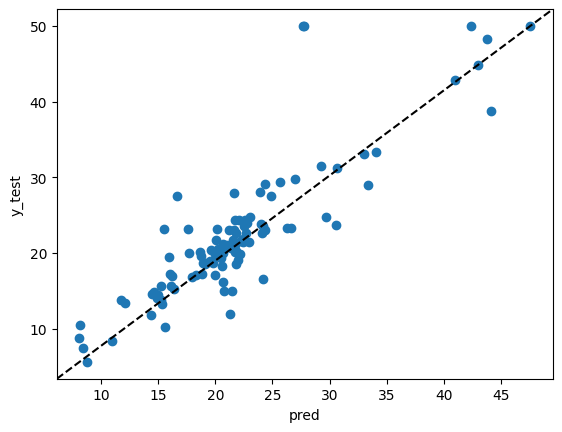

In [77]:
pred = bagged_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [78]:
# Random forests: using 6 features
random_forest_boston = RandomForestRegressor(max_features = 6, random_state = 1)

random_forest_boston.fit(X_train, y_train)

pred = random_forest_boston.predict(X_test)
mean_squared_error(y_test, pred)

22.080069764705893

The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `feature_importances_` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

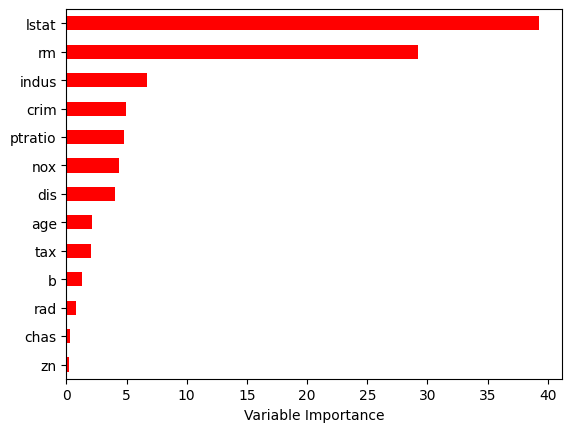

In [79]:
Importance = pd.DataFrame({'Importance':random_forest_boston.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

# 4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [80]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.01, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

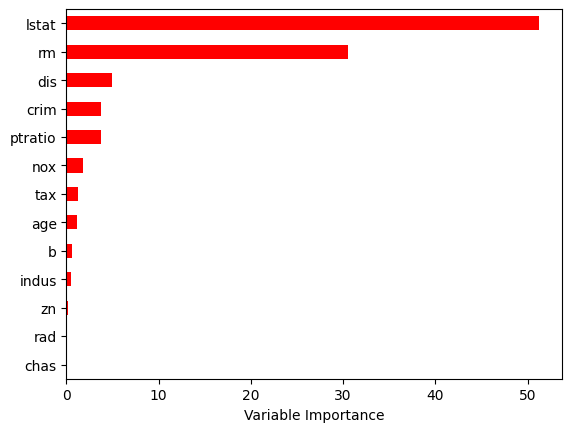

In [81]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [82]:
mean_squared_error(y_test, boosted_boston.predict(X_test))

19.046377762502416

The test MSE obtained is similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [83]:
boosted_boston2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_boston2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_boston2.predict(X_test))

17.667086952596446

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:


<font color='limegreen'>

Here are my observations:

- What's one real-world scenario where you might try using Bagging?
    - To aggregate multiple machine learning algorithms, then predict the data more accurately.
    - For example, in order to predict target labels, we can output predicted values by employing the majority votes; each predicted value will be generated from each algorithm.
    
<br><br>

- What's one real-world scenario where you might try using Random Forests?
    - One of the advantages of a random forest could be reducing the overfitting that will be caused by a single tree.
    - Considering that the tree diagram is likely to be more straightforward for those who do not have expertise in the machine learning algorithm, the application of random forest will be broader.
    - For example, the random forest can be utilized to predict who will be highly likely to default in the bank.
    - Even though there are many independent variables, the ouverfitting risk will be mitigated compared to a single tree diagram.
    
<br><br>

- What's one real-world scenario where you might try using Boosting?
    - Boosting can be used for stock market predictions.
    - Considering that the stocks are highly affected by various factors, such as economic indicators, money flows, and investor sentiment, it would be a good strategy to strive to predict the errors between the actual and predicted values from the previous algorithm.
    - For example, we initially apply the Consumer Price Index (CPI) as an independent variable in the first algorithm, and then we can apply different economic indicators to capture the unpredicted fluctuations that the development of the CPI cannot explain.
    - Once we add more data, the aggregated model could perform better prediction.

 </font>